In [1]:
# Reconstruct strain profiles from phase gradient information

In [2]:
%load_ext autoreload
%autoreload 2

In [26]:
import numpy as np
import tensorflow as tf
from mbptycho.code.utils import circular_gradient
from mbptycho.code.simulation import reloadSimulation
import matplotlib.pyplot as plt

In [11]:
strain_type = 'point_inclusion'
data_path =  f'/raid/home/skandel/code/mbptycho/experiments/python/{strain_type}/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

probes_3d_path = '/raid/home/skandel/code/mbptycho/experiments/matlab/datasets/probe_02.mat'

In [12]:
sm = reloadSimulation(sim_data_path, reload_sim=True, 
                      new_sim_params={'poisson_noise':True, 
                                      'probes_matlab_file':probes_3d_path},
                      new_extra_sample_params={'strain_type':strain_type})#sim_params={"HKL_list":[[1, 2, 0]]}

File exists. Reloading...


In [13]:
np.loadz??

Object `np.loadz` not found.


In [22]:
rho_recons = np.load(data_path + 'rho_out.npz')['arr_0']

In [29]:
np.angle(rho_recons[0])

array([[-0.83949834, -0.741323  , -0.7246467 , ..., -3.066749  ,
        -3.0732102 , -3.0626514 ],
       [-0.76252437, -0.6937705 , -0.6295952 , ..., -3.0378594 ,
        -3.0268924 , -3.034968  ],
       [-0.65263766, -0.5284742 , -0.58171755, ..., -3.0162308 ,
        -3.0252569 , -3.0324674 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.4761465 ,
        -1.4625962 , -1.6289765 ],
       [ 0.        ,  0.        ,  0.        , ..., -1.5084627 ,
        -1.4845967 , -1.5997853 ],
       [ 0.        ,  0.        ,  0.        , ..., -1.5389004 ,
        -1.5085536 , -1.6135408 ]], dtype=float32)

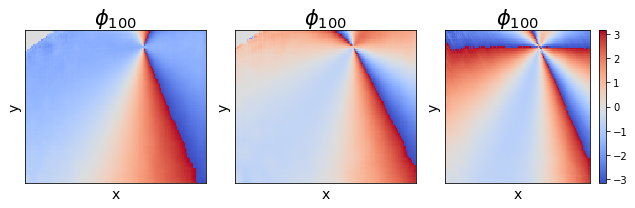

In [32]:
plt.figure(figsize=[9,3])
for i, arr in enumerate(rho_recons):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(np.angle(arr), cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title(r"$\phi_{100}$", fontsize=21)
    plt.xticks([])
    plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()